## interplay between nucleosome repair, eviction/redeposition, and transcription
### nicole pagane | roberts lab

In [1]:
import scipy.integrate as snt
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
import numpy as np
import random as rnd

%matplotlib inline

pass

/usr/local/lib/python2.7/dist-packages/scipy/__init__.py:111: UserWarning: Numpy 1.6.2 or above is recommended for this version of scipy (detected version 1.6.1)
  UserWarning)


In [2]:
# declare universal constants
NUC_SPACE = 45 
OCT_LEN =  126 #147
HEX_LEN = 107*OCT_LEN/147
NUC_UNWRAP = 40
LOOP_OCT = 100*OCT_LEN/147
LOOP_HEX = 71*OCT_LEN/147
NUC_MOVE_OCT = 72
NUC_MOVE_HEX = NUC_MOVE_OCT*LOOP_HEX/LOOP_OCT

print HEX_LEN, LOOP_OCT, LOOP_HEX, NUC_MOVE_OCT, NUC_MOVE_HEX

91 85 60 72 50


In [3]:
# initialize system without further knowledge of isw2 and isw1a mechanisms
# this is derived from results of statistical positioning

# intialize gene
def initializeGene(nucLen = OCT_LEN, geneLen = 2000, linker = NUC_SPACE, density = 0.9):
    gene = np.zeros(geneLen)
    # check the density 
    N = int(np.round(density*geneLen/(nucLen + linker)))
    ind = 0
    nucNum = 1
    while ind + nucLen < geneLen and nucNum < N+1:
        gene[ind:ind+nucLen] = nucNum
        spc = linker
        ind = ind + nucLen + spc
        nucNum += 1
    return gene

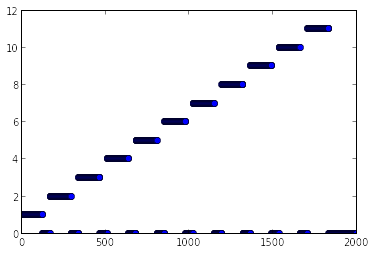

In [4]:
gene = initializeGene()
plt.plot(gene, 'o')
plt.show()

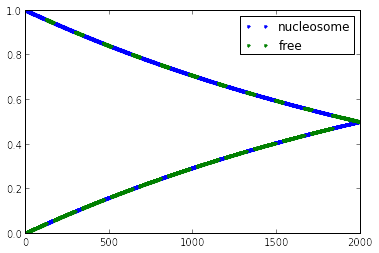

In [5]:
# define gene occupancy expectation
def geneOccupancy(g):
    x = np.linspace(1, len(g), len(g))
    k = -np.log(0.5)
    y = np.exp(-k*x/len(g))
    gScale = np.ceil(g/max(g))*y
    for i in range(len(g)):
        if gScale[i] == 0:
            gScale[i] = 1-y[i]
    return gScale


gRef = geneOccupancy(initializeGene())
plt.plot(gRef, '.', label='nucleosome')
plt.plot(1-gRef, '.', label='free')
plt.legend()
plt.show()

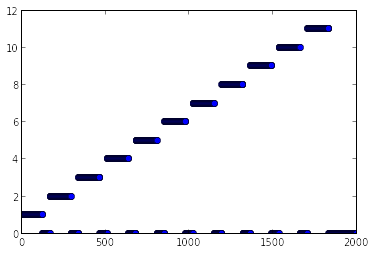

{0.0: 0, 1.0: 45, 2.0: 45, 3.0: 45, 4.0: 45, 5.0: 45, 6.0: 45, 7.0: 45, 8.0: 45, 9.0: 45, 10.0: 45, 11.0: 165}


In [6]:
# determine spacing
def detSpace(g):
    gene = np.linspace(0, len(g)-1, len(g))
    space = {}
    nucs = np.unique(g)
    for i in range(1,len(nucs)):
        lowBound = np.asarray(gene[g==nucs[i-1]], int)
        if nucs[i-1] == 0: lowBound = [-1];
        space[nucs[i-1]] = np.asarray(gene[g==nucs[i]], int)[0] - lowBound[-1] - 1
    # append last nuc spacing to end of gene
    space[nucs[-1]] = len(g) - np.asarray(gene[g==nucs[-1]], int)[-1]
    return space

plt.plot(gene, 'o')
plt.show()
print detSpace(gene)

In [31]:
kB = 1.38e-23; T = 295
ecoeff = 3.0/2
kspring = ecoeff*2*kB*T/(NUC_SPACE/3*1e-9)**2

# define energy calculation
def energy(g):
    spc = detSpace(g); spcSort = np.argsort(spc.keys()); spc = spc.values(); spc = np.asarray(spc)[spcSort]
    spc = spc[1:len(spc)-1]; spc = np.asarray(spc) # remove the pre +1 linker and remaining space
    en = 0.5*kspring*((NUC_SPACE - spc)/3*1e-9)**2
    k = -np.log(0.5)
    x = np.linspace(0, len(spc), len(spc))
    en *= np.exp(-k*x*1.0/len(spc)) 
    return np.sum(en)

0.308080808081


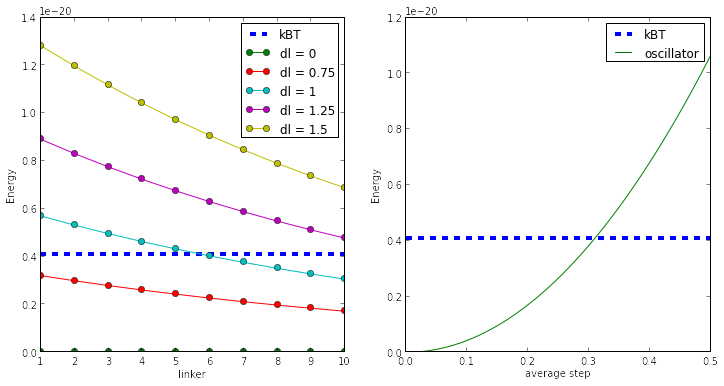

In [32]:
fig = plt.figure(figsize=(12,6))
x = detSpace(initializeGene()); spcSort = np.argsort(x.keys()); x = x.values(); x = np.asarray(x)[spcSort]
x = x[1:len(x)-1];

k = -np.log(0.5)
y = np.linspace(1, len(x), len(x))

xVec = [1, 1.75, 2, 2.25, 2.5]

ax = fig.add_subplot(1,2,1)
ax.plot(y, np.ones(len(x))*kB*T, '--', label = 'kBT', linewidth = 4)

eSum = []
for i in xVec:
    xnew = i*np.asarray(x) # remove the pre +1 linker and remaining space
    en = 0.5*kspring*((NUC_SPACE - xnew)/3*1e-9)**2
    en *= np.exp(-k*y*1.0/len(x)) 
    ax.plot(y, en, '-o', label = 'dl = ' + str(i-1))
    eSum.append(np.sum(en))
    
ax.set_xlabel('linker'); ax.set_ylabel('Energy')
ax.legend()

xVec2 = np.linspace(1, 1.5, 100)
ax = fig.add_subplot(1,2,2)
ax.plot(xVec2-1, np.ones(len(xVec2))*kB*T, '--', label = 'kBT', linewidth = 4)

y = np.linspace(1, len(x), len(x))
eSum = []
for i in xVec2:
    xnew = i*np.asarray(x) # remove the pre +1 linker and remaining space
    en = 0.5*kspring*((NUC_SPACE - xnew)/3*1e-9)**2
    en *= np.exp(-k*y*1.0/len(x)) 
    eSum.append(np.sum(en))

ax.plot(xVec2-1, eSum, label = 'oscillator')
ax.set_xlabel('average step'); ax.set_ylabel('Energy')
ax.legend()

stepSize = xVec2[np.argsort(np.abs(np.asarray(eSum) - kB*T))[0]] - 1
print stepSize 

plt.show()

In [38]:
# MCMC to simulate nucleosome shuffling
def MCMC(g = initializeGene(), N = 1000):
    N = int(N)
    curE = energy(g); lowE = curE
    eVec = []
    propG = np.zeros(len(g))
    gSum = np.ceil(g/max(g))
    gState = np.zeros(len(g)); gState = g[:]*1.0 # shallow copy
    # check that there is more than one nuc left
    if len(set(g)) <= 2:
        return gState, eVec, gSum # quit since dynamics of one nucleosome is not interesting
    ming = np.unique(g)[2] # since 0 = linker, 1 = +1 nuc
    maxg = max(g)+1
    for i in range(N):
        # select random nucleosome
        propNuc = np.random.randint(ming, maxg) 
        propInd = np.array(np.linspace(0, len(g)-1, len(g))[g == propNuc], int) 
        # select random movement
        propMove = int(np.random.normal(0, stepSize*NUC_SPACE)) # sample from normal w spread nuc len
        # implement proposed movement
        move = propInd + propMove
        moveTrim = move[move >= 0]
        move = moveTrim[moveTrim < len(g)]
        # check for collision
        propG = g[:]*1.0 # shallow copy
        propG[propInd] = 0
        if (np.sum(propG[move]) == 0 and len(move) == len(propInd)):
            propG[move] = propNuc
            # metropolis criterion
            propE = energy(propG)
            delE = propE - curE
            rand = np.random.rand()
            if (rand < np.exp(-delE/(kB*T))):
                # accept change
                g = propG[:]*1.0 #shallow copy
                curE = propE
            if (i >= 1.0*N/2): # reject the first half off the simulation
                gSum += np.ceil(g/max(g))
                eVec.append(curE)
                # save lowest energy config
                if propE < lowE:
                    gState = g[:]*1.0
                    lowE = propE
    return gState, eVec, gSum

In [44]:
ltest = int(0.5*NUC_SPACE)
dens = 0.5
gene = initializeGene(linker = ltest, density = dens)

n1 = 500; n2 = 1500; n3 = 5000

gene1, eVec1, gA1= MCMC(gene, n1)
gene2, eVec2, gA2 = MCMC(gene, n2)
gene3, eVec3, gA3 = MCMC(gene, n3)

allowed moves for 1: 232
allowed moves for 2: 693
allowed moves for 3: 2316


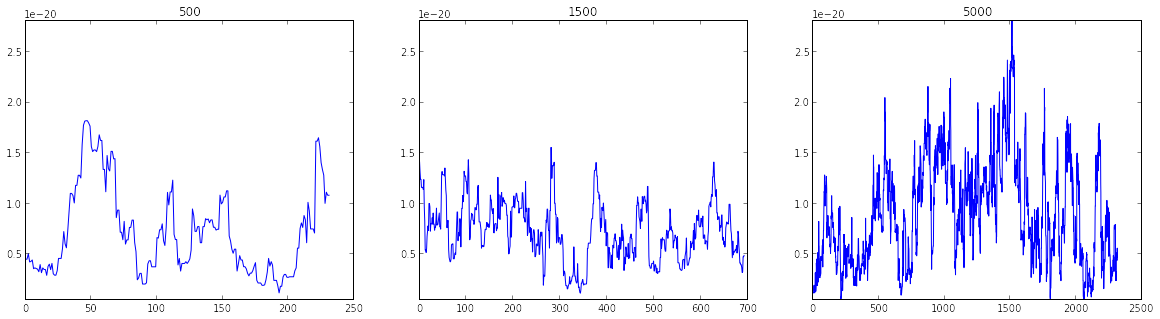

In [45]:
print 'allowed moves for 1: ' + str(len(eVec1))
print 'allowed moves for 2: ' + str(len(eVec2))
print 'allowed moves for 3: ' + str(len(eVec3))

totE = []; totE.extend(eVec1); totE.extend(eVec2); totE.extend(eVec3)

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,3,1)
ax.set_ylim([min(totE), max(totE)])
ax.set_title(n1)
ax.plot(eVec1)
ax = fig.add_subplot(1,3,2)
ax.set_ylim([min(totE), max(totE)])
ax.set_title(n2)
ax.plot(eVec2)
ax = fig.add_subplot(1,3,3)
ax.set_ylim([min(totE), max(totE)])
ax.set_title(n3)
ax.plot(eVec3)

plt.show()

intial energy  5.80153018097e-21


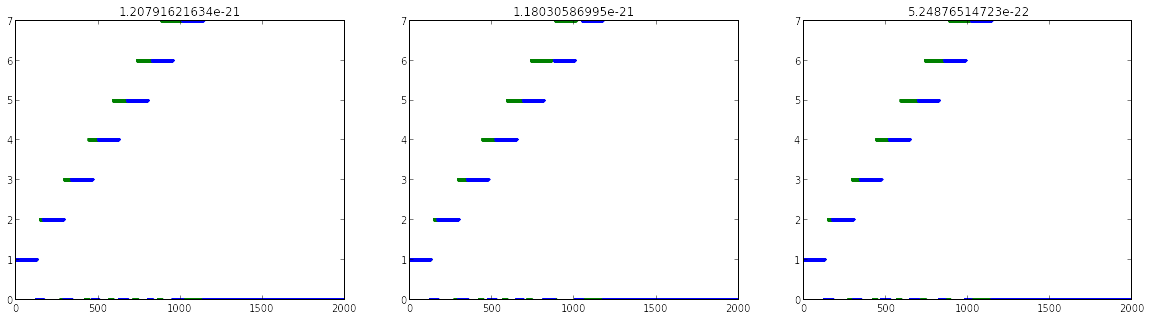

In [46]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,3,1)
ax.set_title(n1)
ax.plot(gene, 'g.')
ax.plot(gene1, 'b.')
ax.set_title(energy(gene1))
ax = fig.add_subplot(1,3,2)
ax.set_title(n2)
ax.plot(gene, 'g.')
ax.plot(gene2, 'b.')
ax.set_title(energy(gene2))
ax = fig.add_subplot(1,3,3)
ax.set_title(n3)
ax.plot(gene, 'g.')
ax.plot(gene3, 'b.')
ax.set_title(energy(gene3))

print 'intial energy ', energy(gene)

plt.show()

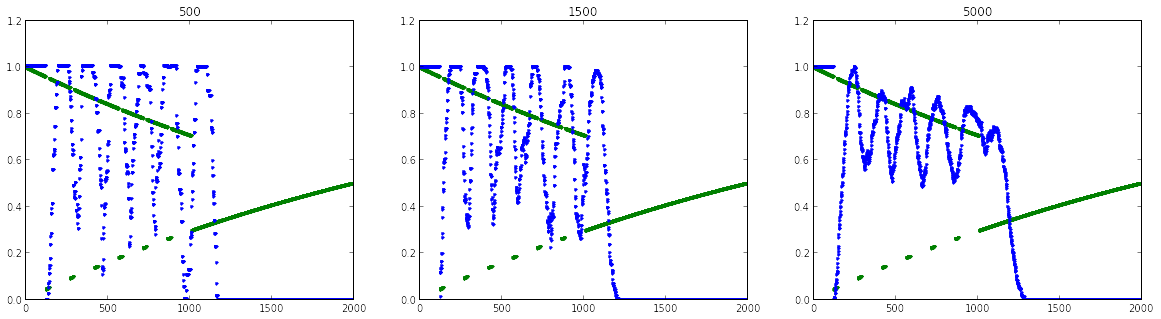

In [47]:
# reference
gRef = geneOccupancy(initializeGene(linker = ltest, density = dens))

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,3,1)
ax.set_title(n1)
ax.plot(gRef, 'g.')
ax.plot(gA1/len(eVec1), 'b.')
ax = fig.add_subplot(1,3,2)
ax.set_title(n2)
ax.plot(gRef, 'g.')
ax.plot(gA2/len(eVec2), 'b.')
ax = fig.add_subplot(1,3,3)
ax.set_title(n3)
ax.plot(gRef, 'g.')
ax.plot(gA3/len(eVec3), 'b.')

plt.show()

### add transcription

In [48]:
# probs from paper 
kue = 1; N = 40; Nt = 147; kt = 0.02; kd = 0.027
phex = (kue/(kt+kue))**N * ((kd/(kt+kd)) + (kt/(kt+kd)) * (kue/(kt+kue+kd))**(Nt-N)) - (kue/(kt+kue))**Nt
poct = 1.0 - (kue/(kt+kue))**N * ((kd/(kt+kd)) + (kt/(kt+kd)) * (kue/(kt+kue+kd))**(Nt-N))
pfree = (kue/(kt+kue))**Nt

print 'prob of hex: ', phex*100 
print 'prob of oct: ', poct*100
print 'prob of free: ', pfree*100

prob of hex:  20.7163647036
prob of oct:  73.8414321259
prob of free:  5.44220317046


In [49]:
# define RNAP passage effects
def RNAP(g):
    # check that there is more than one nuc left
    if len(set(g)) <= 2:
        return g # quit since dynamics of one nucleosome is not interesting
    temp = np.zeros(len(g))
    spc = detSpace(g)
    nucs = np.sort(spc.keys())
    # attempt movement on the post +1 nucleosomes
    i = 1
    while (i < len(spc)-1):
        nuc = np.asarray(np.linspace(0, len(g)-1, len(g))[g==nucs[i+1]], dtype = int)
        if (spc[nucs[i]] + NUC_UNWRAP >= LOOP_OCT and len(g[nuc]) == OCT_LEN): # octosome
            # randomly determine fate of octomer from above probabilities
            rand = np.random.random()
            if rand < pfree: # remove octomer
                g[nuc] = 0 
            elif rand < (pfree+phex): # lose dimer and move upstream
                g[nuc] = 0 
                # shave off sides
                side = (OCT_LEN-HEX_LEN)/2
                nuc = np.asarray(np.linspace(min(nuc)+side, max(nuc)-side, HEX_LEN), dtype = int)
                add = NUC_UNWRAP
                if spc[nucs[i]] > NUC_MOVE_HEX: add = 0
                g[np.asarray(nuc - NUC_MOVE_HEX + add, int)] = int(nucs[i+1]) 
            else: # move upstream as octomer
                g[nuc] = 0 
                add = NUC_UNWRAP
                if spc[nucs[i]] > NUC_MOVE_OCT: add = 0
                g[np.asarray(nuc - NUC_MOVE_OCT + add, int)] = int(nucs[i+1])
        elif (spc[nucs[i]] + NUC_UNWRAP >= LOOP_HEX and len(g[nuc]) == HEX_LEN): # hexasome
             # randomly determine fate of octomer from above probabilities
                rand = np.random.random()
                if rand < pfree/(pfree+phex): # remove hexasome (reweighted probs)
                    g[nuc] = 0 
                else: # move hexasome
                    g[nuc] = 0 
                    add = NUC_UNWRAP
                    if spc[nucs[i]] > NUC_MOVE_HEX: add = 0
                    g[np.asarray(nuc - NUC_MOVE_HEX + add, int)] = int(nucs[i+1])
        else: # remove nucleosome due to crowding or make hexasome
            g[nuc] = 0
        i += 1
        spc = detSpace(g)
        nucs = np.sort(spc.keys())
    return g

In [50]:
cycles = 10
gene = []
en = []
g = initializeGene();
gAv = []
for i in range(cycles):
    g = RNAP(g)
    gempty = np.sum(g == 0)
    if gempty == (len(g) - OCT_LEN) or len(g[g == 1]) != OCT_LEN:
        print 'terminated early since only one left'
        break
    en.append(energy(g)); gAv.append(np.ceil(g/max(g)))
    print 'trans ', i+1, ': ', detSpace(g).values()
    g, e, gA = MCMC(g, 1000)
    gene.append(g); en.extend(e); gAv.append(gA/len(e))
    print 'relax ', i+1, ': ', detSpace(g).values()

trans  1 :  [0, 13, 5, 84, 79, 40, 45, 45, 45, 45, 45, 237]
relax  1 :  [0, 57, 63, 28, 39, 50, 44, 44, 50, 69, 56, 183]
trans  2 :  [0, 25, 23, 50, 39, 28, 44, 83, 45, 69, 56, 255]
relax  2 :  [0, 44, 50, 37, 48, 40, 16, 33, 78, 63, 56, 252]
trans  3 :  [0, 220, 27, 8, 232, 23, 55, 97, 51, 324]
relax  3 :  [0, 112, 88, 78, 88, 111, 85, 41, 51, 383]
trans  4 :  [0, 40, 110, 308, 61, 85, 234, 383]
relax  4 :  [0, 65, 90, 132, 145, 112, 90, 587]
trans  5 :  [0, 33, 72, 110, 421, 18, 659]
relax  5 :  [0, 57, 47, 89, 107, 52, 961]
trans  6 :  [0, 24, 64, 67, 129, 30, 1033]
relax  6 :  [0, 47, 42, 44, 99, 78, 1037]
trans  7 :  [0, 37, 2, 61, 336, 1037]
relax  7 :  [0, 37, 39, 36, 52, 1309]
trans  8 :  [0, 27, 39, 36, 30, 1341]
relax  8 :  [0, 55, 49, 37, 41, 1291]
trans  9 :  [0, 5, 49, 37, 19, 1363]
relax  9 :  [0, 43, 44, 48, 44, 1294]
trans  10 :  [0, 33, 4, 48, 22, 1366]
relax  10 :  [0, 29, 17, 40, 43, 1344]


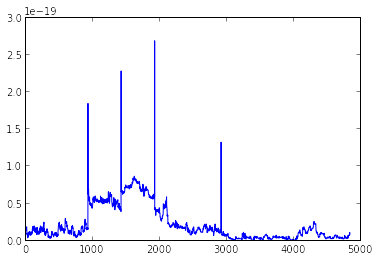

In [51]:
plt.plot(en)
plt.show()

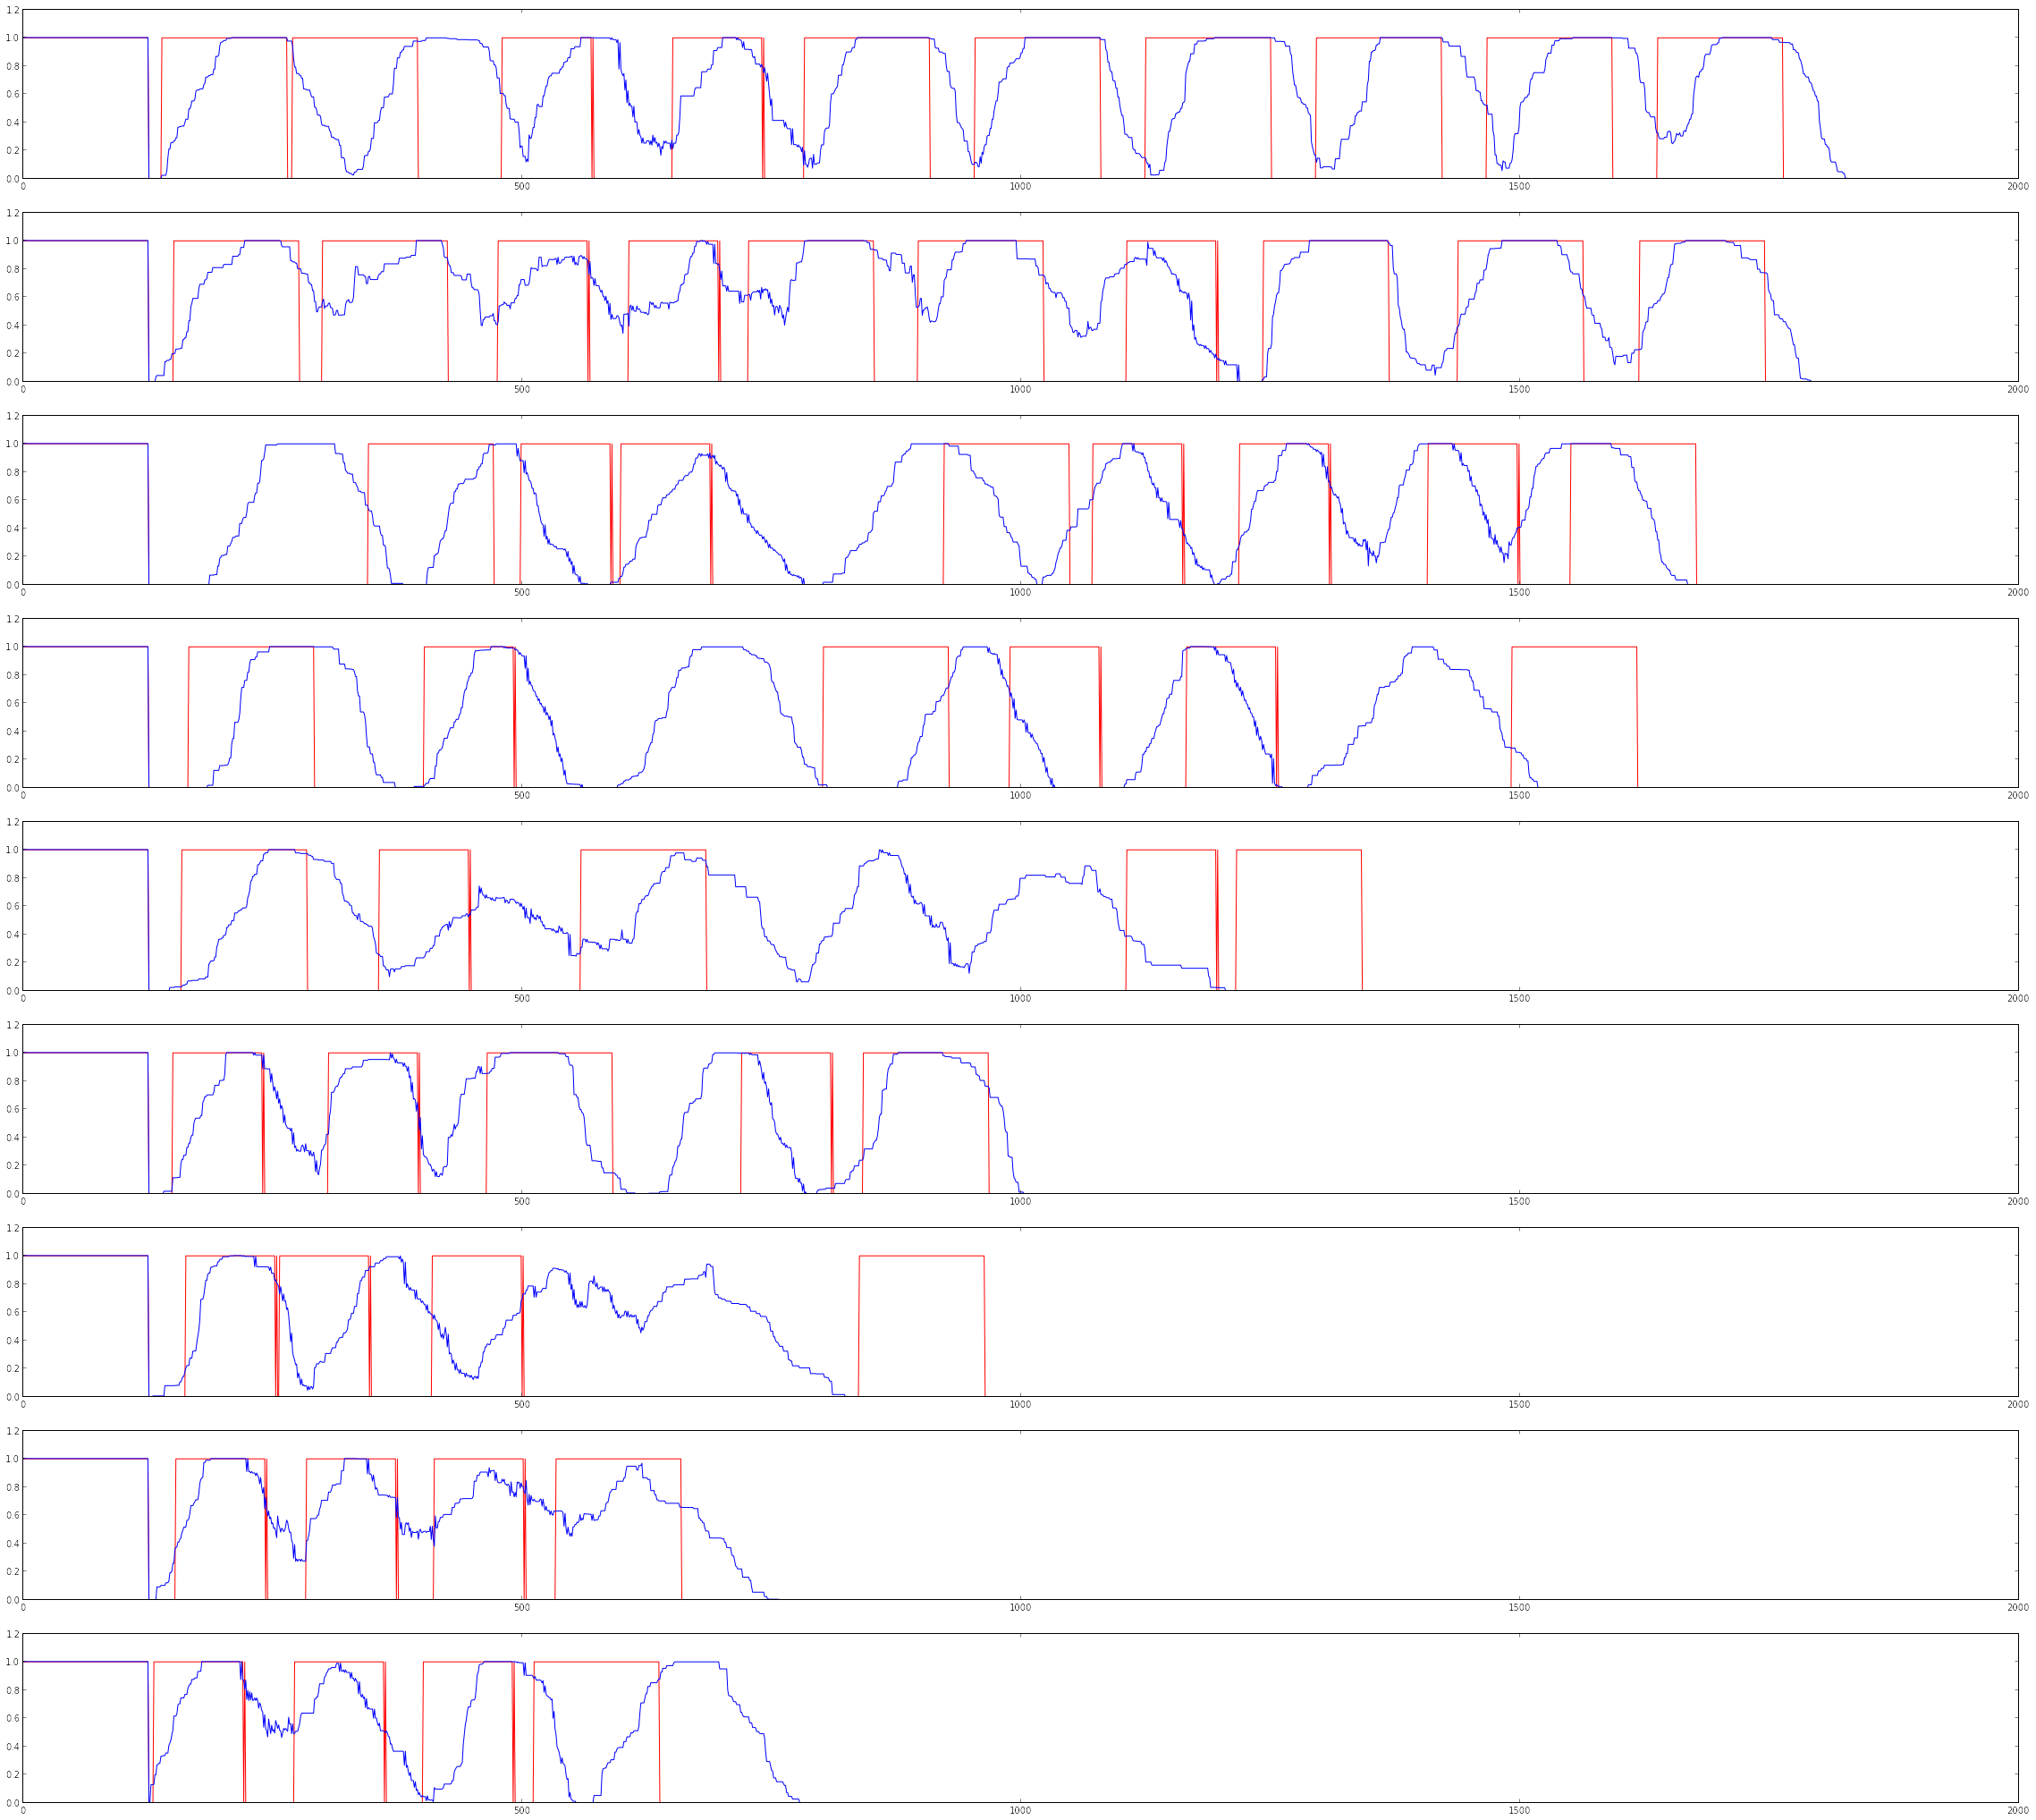

In [52]:
fig = plt.figure(figsize=(4*cycles, 4*cycles))
ind = 0; pltInd = 0
while ind < 2*i:
    ax = fig.add_subplot(cycles,1,pltInd+1)
    ax.plot(gAv[ind], 'r-')
    ax.plot(gAv[ind+1], 'b-')
    ind += 2; pltInd += 1
    
plt.show()

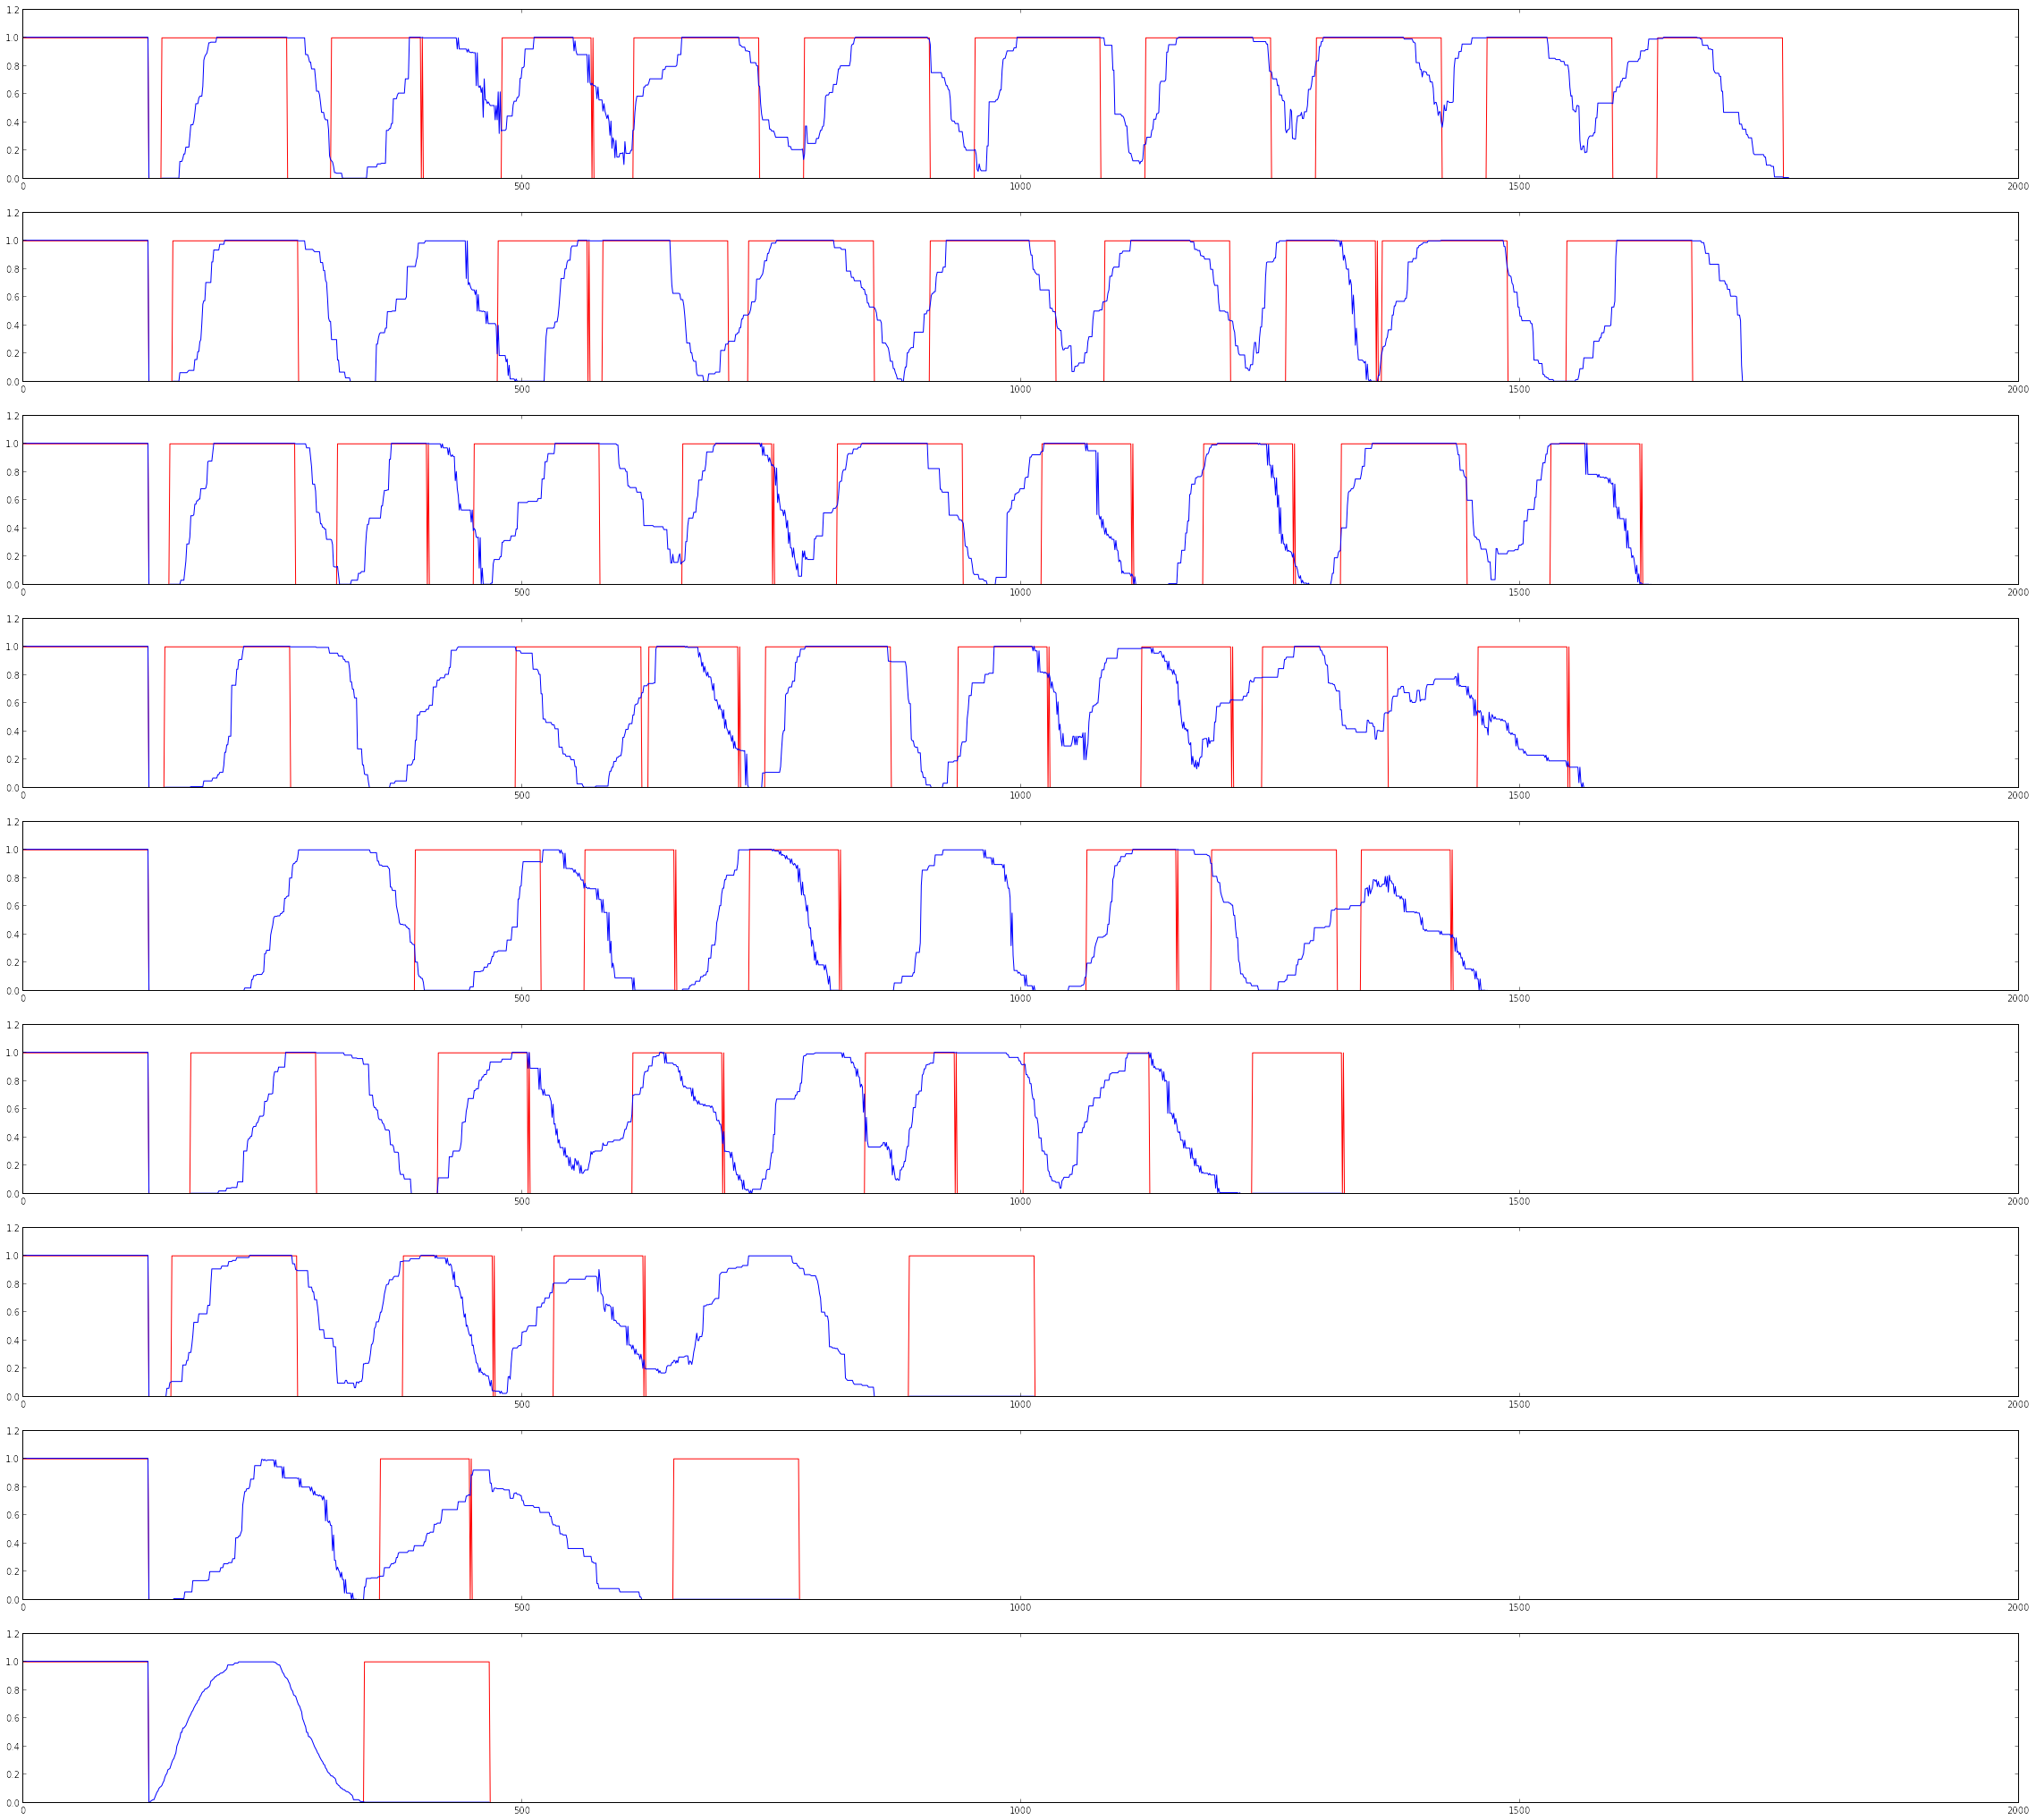

In [53]:
cycles = 10
gene = []
en = []
g = initializeGene(); gene.append(g)
gAv = []
for i in range(cycles):
    g = RNAP(g)
    gempty = np.sum(g == 0)
    if gempty == (len(g) - OCT_LEN) or len(g[g == 1]) != OCT_LEN:
        print 'terminated early since only one left'
        break
    gene.append(g); en.append(energy(g)); gAv.append(np.ceil(g/max(g)))
    g, e, gA = MCMC(g, 500)
    gene.append(g); en.extend(e); gAv.append(gA/len(e))

fig = plt.figure(figsize=(4*cycles, 4*cycles))
ind = 0; pltInd = 0
while ind < 2*i:
    ax = fig.add_subplot(cycles,1,pltInd+1)
    ax.plot(gAv[ind], 'r-')
    ax.plot(gAv[ind+1], 'b-')
    ind += 2; pltInd += 1
    
plt.show()

In [ ]:
# run several simulations varying transcription rate to gather statistics
runs = {}
cycles = 10
reps = 30
geneLen = 2000
pts = 10
minFreq = 500
maxFreq = 5000

for trate in np.linspace(minFreq,maxFreq,pts):
    gene = np.zeros(geneLen); avgE = 0; nucR = 0; finE = 0; avgN = 0
    for rep in range(reps):
        en = []
        g = initializeGene()
        ncount = 0
        for i in range(cycles):
            g = RNAP(g);
            gempty = np.sum(g == 0)
            if gempty == (len(g) - OCT_LEN):
                break
            en.append(energy(g));
            g, e, gA = MCMC(g, int(trate)); en.append(np.min(e))
            ncount += 1.0*(len(detSpace(g)) - 1)/cycles
        gene += np.ceil(g/max(g))/reps; avgE += np.mean(en)/reps; 
        nucR += 1.0*(len(detSpace(g)) - 1)/reps; finE += energy(g)/reps; avgN += ncount/reps
    runs[int(trate)] = [gene, avgE, finE, avgN, nucR]
    print reps, ' sims for MCMC iter ', int(trate), ' done'
print 'done'

In [ ]:
# plot energy
aen = []
men = []
trate = []
count = 0
for i in runs.keys():
    trate.append(i)
    aen.append(runs[i][1])
    men.append(runs[i][2])
    
order = np.argsort(trate)
trate = np.asarray(trate)[order]; men = np.asarray(men)[order]; aen = np.asarray(aen)[order]

fig, ax1 = plt.subplots()
minplot = 0
color = 'red'
ax1.set_xlabel('MCMC iterations')
ax1.set_ylabel('average energy', color=color)
ax1.plot(trate[minplot:], aen[minplot:], 'o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'blue'
ax2.set_ylabel('minimum energy', color=color)  # we already handled the x-label with ax1
ax2.plot(trate[minplot:], men[minplot:], 'o', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped


plt.show()

In [ ]:
fig = plt.figure(figsize = (20,20))

pltInd = 0
keys = np.sort(runs.keys())
for i in keys:
    ax = fig.add_subplot(np.ceil(pts/2),np.floor(pts/2),pltInd+1)
    ax.plot(runs[i][0], '-')
    ax.set_title(i)
    pltInd += 1
    
plt.xlabel('MCMC iter'); plt.ylabel('avg nucs')
plt.show()

In [ ]:
keys = np.sort(runs.keys())
y = []
y2 = []
for i in keys:
    y.append(runs[i][3])
    y2.append(runs[i][4])


order = np.argsort(trate)
trate = np.asarray(trate)[order]; y = np.asarray(y)[order]; y2 = np.asarray(y2)[order]

fig, ax1 = plt.subplots()
minplot = 0
color = 'red'
ax1.set_xlabel('MCMC iterations')
ax1.set_ylabel('average nucs', color=color)
ax1.plot(trate[minplot:], y[minplot:], 'o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'blue'
ax2.set_ylabel('remaining nucs', color=color)  # we already handled the x-label with ax1
ax2.plot(trate[minplot:], y2[minplot:], 'o', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped


plt.show()

plt.show()

### dimer replacement

In [ ]:
def repair(g, prep):
    spc = detSpace(g)
    nucs = np.sort(spc.keys()); nucs = np.asarray(nucs, int)
    hexes = []
    #temp = np.zeros(len(g))
    i = 1
    while (i < len(spc)):
        #temp = g[:]*1.0
        nuc = np.asarray(np.linspace(0, len(g)-1, len(g))[g==nucs[i]], int)
        if (len(nuc) == HEX_LEN): # ensure that a hexasome is selected for
            rand = np.random.rand()
            if rand < prep and spc[nucs[i]] > (OCT_LEN-HEX_LEN)/2 and spc[nucs[i-1]] > (OCT_LEN-HEX_LEN)/2:
                # repair nuc
                g[nuc] = 0 #temp[nuc] = 0
                # add nuc sides
                side = (OCT_LEN-HEX_LEN)/2
                nuc = np.asarray(np.linspace(min(nuc)-side, max(nuc)+side, OCT_LEN), int)
                g[nuc] = i
        #g = temp[:]*1.0
        spc = detSpace(g)
        nucs = np.sort(spc.keys()); nucs = np.asarray(nucs, int)
        i += 1
    return g

In [ ]:
g = initializeGene()
plt.plot(g, label = 'og')
g = RNAP(g)
plt.plot(g, label = 'trans')
#g, e, ga = MCMC(g, 500)
g = repair(g, 1.0)
#g, e, ga = MCMC(g, 500)
plt.plot(g, '--', label = 'rep')

plt.legend()
plt.show()

In [ ]:
cycles = 10
gene = []
en = []
g = initializeGene()
gAv = []
for i in range(cycles):
    g = RNAP(g)
    gempty = np.sum(g == 0)
    if gempty == len(g) or gempty == (len(g) - OCT_LEN) or gempty == (len(g) - HEX_LEN):
        print 'terminated at', i, ' since only one left'
        break
    en.append(energy(g)); gAv.append(np.ceil(g/max(g)))
    g, e, gA = MCMC(g, 250); en.extend(e); gAv.append(gA/len(e))
    g = repair(g, 0.5); en.append(energy(g)); gAv.append(np.ceil(g/max(g)))
    g, e, gA = MCMC(g, 250); en.extend(e); gAv.append(gA/len(e))

fig = plt.figure(figsize=(4*cycles, 4*cycles))
ind = 0; pltInd = 0
while ind < 2*i:
    ax = fig.add_subplot(cycles,1,pltInd+1)
    ax.plot(gAv[ind], 'r-')
    ax.plot(gAv[ind+1], 'b-')
    ind += 2; pltInd += 1
    
plt.show()

In [ ]:
import time

# run several simulations varying transcription rate to gather statistics
runs2 = {}
cycles = 10
reps = 30
geneLen = 2000
pts = 10
minFreq = 500
maxFreq = 5000

start = time.time()
counter = 0
for prep in np.linspace(0,1.0, pts):
    key1 = str(np.round(prep, 2))
    runs2[key1] = {}
    for trate in np.linspace(minFreq,maxFreq,pts):
        key2 = str(np.round(trate))
        runs2[key1][key2] = {}
        gene = np.zeros(geneLen); avgE = 0; nucR = 0; finE = 0; avgN = 0
        for rep in range(reps):
            en = []
            g = initializeGene()
            ncount = 0
            for i in range(cycles):
                g = RNAP(g);
                gempty = np.sum(g == 0)
                if gempty == len(g) or gempty == (len(g) - OCT_LEN) or gempty == (len(g) - HEX_LEN):
                    break
                en.append(energy(g));
                g, e, gA = MCMC(g, int(1.0*trate/2)); temp = e
                g = repair(g, prep); en.append(energy(g))
                g, e, gA = MCMC(g, int(1.0*trate/2)); e.extend(temp); en.append(np.min(e))
                ncount += 1.0*(len(detSpace(g)) - 1)/cycles
            gene += np.ceil(g/max(g))/reps; avgE += np.mean(en)/reps; 
            nucR += 1.0*(len(detSpace(g)) - 1)/reps; finE += energy(g)/reps; avgN += ncount/reps
        runs2[key1][key2] = [gene, avgE, finE, avgN, nucR]
        counter += 1
        print '[', key1, ' ', key2, '] done (', counter, 'of', pts**2, ')'

stop = time.time()        

print 'done, in ', 1.0*(stop - start)/3600, 'hr'

In [ ]:
# save data if it looks good to avoid running again?
import csv
import os 

#os.chdir('./data')
os.getcwd()

w = csv.writer(open('2dtrials2.csv', 'w'))
for key, val in runs2.items():
    w.writerow([key, val])

### analysis

In [ ]:
finEVec = np.zeros([pts, pts])
avgEVec = np.zeros([pts, pts])
posVec = [[0 for i in range(pts)] for j in range(pts)]
nucRVec = np.zeros([pts, pts])
nucAVec = np.zeros([pts, pts])
pkeys = np.sort(np.asarray(runs2.keys()))
tkeys = np.sort(np.asarray(runs2[pkeys[0]].keys()))
pVec = []
tVec = []
for i in range(len(pkeys)):
    for j in range(len(tkeys)):
        posVec[i][j] = runs2[pkeys[i]][tkeys[j]][0]
        avgEVec[i, j] = runs2[pkeys[i]][tkeys[j]][1]
        finEVec[i, j] = runs2[pkeys[i]][tkeys[j]][2]
        nucAVec[i, j] = runs2[pkeys[i]][tkeys[j]][3]
        nucRVec[i, j] = runs2[pkeys[i]][tkeys[j]][4]
        pVec.append(float(pkeys[i])); tVec.append(float(tkeys[j]))

In [ ]:
ucut = 5e-23

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(121)
surf = ax.imshow(avgEVec.T, cmap = 'jet', origin = 'lower',
                extent = (pVec[0], pVec[-1], tVec[0]/max(np.asarray(tVec)), tVec[-1]/max(np.asarray(tVec))))
fig.colorbar(surf, shrink = 0.5)
ax.set_title('average energy throughout timecourse')
ax.set_xlabel('probability of repair'); ax.set_ylabel('MCMC iterations (1e-5)')

ax = fig.add_subplot(122)
surf = ax.imshow(finEVec.T, cmap = 'jet', origin = 'lower', vmax = ucut,
                extent = (pVec[0], pVec[-1], tVec[0]/max(np.asarray(tVec)), tVec[-1]/max(np.asarray(tVec))))
fig.colorbar(surf, shrink = 0.5)
ax.set_title('final energy after 10 rounds of transcription')
ax.set_xlabel('probability of repair'); ax.set_ylabel('MCMC iterations (1e-5)')

plt.show()

In [ ]:
# 3D PLOTTING 
# of energy by prob and rate
from mpl_toolkits import mplot3d
from matplotlib.colors import LogNorm

fig = plt.figure(figsize = (20,10))

ax = fig.add_subplot(121,projection = '3d')

surf = ax.scatter(tVec, pVec, avgEVec, s= 100, c = avgEVec, cmap= 'jet')

ax.set_ylabel('probability of repair'); ax.set_xlabel('frequency of transcription'); ax.set_zlabel('average energy')

ax = fig.add_subplot(122,projection = '3d')

surf = ax.scatter(tVec, pVec, np.clip(finEVec, 0, ucut), s= 100, c = np.clip(finEVec, 0, ucut), cmap= 'jet')

ax.set_ylabel('probability of repair'); ax.set_xlabel('frequency of transcription'); ax.set_zlabel('final energy')

plt.show()

In [ ]:
fig = plt.figure(figsize = (15,15))

pltInd = 0
for i in pkeys[0::3]:
    for j in tkeys[0::3]:
        ax = fig.add_subplot(4,4,pltInd+1)
        ax.plot(runs2[i][j][0], '-')
        ax.set_title(' and '.join([i, str(np.round(1/(float(j)/max(tVec))))]))
        pltInd += 1
    
plt.xlabel('gene len'); plt.ylabel('avg nucs')


plt.show()

In [ ]:
fig = plt.figure(figsize = (20,10))

ax = fig.add_subplot(121)
surf = ax.imshow(nucRVec, cmap = 'jet', origin = 'lower',
                 extent = (pVec[0], pVec[-1], tVec[0]/max(np.asarray(tVec)), tVec[-1]/max(np.asarray(tVec))))
fig.colorbar(surf, shrink = 0.5)
ax.set_title('average nucleosome count throughout timecourse')
ax.set_xlabel('probability of repair'); ax.set_ylabel('MCMC iterations (1e-5)')

ax = fig.add_subplot(122)
surf = ax.imshow(nucWVec, cmap = 'jet', origin = 'lower', 
                 extent = (pVec[0], pVec[-1], tVec[0]/max(np.asarray(tVec)), tVec[-1]/max(np.asarray(tVec))))
fig.colorbar(surf, shrink = 0.5)
ax.set_title('final nucleosome count after 10 rounds of transcription')
ax.set_xlabel('probability of repair'); ax.set_ylabel('MCMC iterations (1e-5)')

plt.show()

In [ ]:
fig = plt.figure(figsize = (20,10))

ax = fig.add_subplot(121,projection = '3d')

surf = ax.scatter(tVec, pVec, nucRVec, s = 100, c = nucRVec, cmap = 'jet')

ax.set_ylabel('probability of repair'); ax.set_xlabel('frequency of transcription'); ax.set_zlabel('average nucs')

ax = fig.add_subplot(122,projection = '3d')

surf = ax.scatter(tVec, pVec, nucWVec, s = 100, c = nucWVec, cmap = 'jet')

ax.set_ylabel('probability of repair'); ax.set_xlabel('frequency of transcription'); ax.set_zlabel('final nucs')

plt.show()

In [ ]:
fig = plt.figure(figsize = (10,10))

ax = fig.add_subplot(111,projection = '3d')

surf = ax.scatter(tVec, pVec, np.clip(finEVec, 0, ucut)/nucRVec, s = 100, c = np.clip(finEVec, 0, ucut)/nucRVec, cmap = 'jet')

ax.set_ylabel('probability of repair'); ax.set_xlabel('frequency of transcription'); ax.set_zlabel('final energy per nucleosome')

plt.show()